In [1]:
# Download from Google Drive
!gdown --id 18OYbRKPSUcapmGzbxmSfVnz7UMz7OGnO

Downloading...
From: https://drive.google.com/uc?id=18OYbRKPSUcapmGzbxmSfVnz7UMz7OGnO
To: /content/ecg-kaggle.zip
2.72MB [00:00, 86.9MB/s]


In [2]:
!unzip ecg-kaggle.zip

Archive:  ecg-kaggle.zip
   creating: kaggle/
  inflating: __MACOSX/._kaggle       
  inflating: kaggle/Icon             
  inflating: __MACOSX/kaggle/._Icon  
  inflating: kaggle/test.csv         
  inflating: __MACOSX/kaggle/._test.csv  
  inflating: kaggle/train.csv        
  inflating: __MACOSX/kaggle/._train.csv  


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, utils, callbacks, metrics

import cv2
tf.__version__

'2.4.1'

In [8]:
df = pd.read_csv('kaggle/train.csv')
num_classes=5

In [9]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.952899,0.952899,0.653986,0.438406,0.409420,0.403986,0.364130,0.309783,0.268116,0.222826,0.182971,0.146739,0.121377,0.123188,0.110507,0.106884,0.106884,0.094203,0.096014,0.085145,0.081522,0.076087,0.065217,0.057971,0.041667,0.038043,0.019928,0.014493,0.010870,0.000000,0.005435,0.007246,0.019928,0.041667,0.056159,0.079710,0.114130,0.141304,0.172101,0.181159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.964968,0.646497,0.773885,0.366242,0.181529,0.162420,0.149682,0.146497,0.146497,0.136943,0.127389,0.117834,0.111465,0.105096,0.092357,0.092357,0.082803,0.082803,0.063694,0.060510,0.044586,0.041401,0.035032,0.031847,0.019108,0.009554,0.006369,0.006369,0.000000,0.003185,0.003185,0.009554,0.009554,0.025478,0.035032,0.044586,0.063694,0.082803,0.098726,0.114650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.977551,1.000000,0.608163,0.393878,0.369388,0.324490,0.275510,0.226531,0.185714,0.144898,0.114286,0.089796,0.093878,0.077551,0.081633,0.055102,0.075510,0.065306,0.061224,0.051020,0.053061,0.044898,0.032653,0.032653,0.030612,0.014286,0.022449,0.008163,0.022449,0.018367,0.034694,0.055102,0.091837,0.120408,0.148980,0.165306,0.179592,0.165306,0.183673,0.169388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.943878,0.905612,0.706633,0.239796,0.063776,0.150510,0.114796,0.043367,0.015306,0.043367,0.038265,0.048469,0.051020,0.056122,0.066327,0.061224,0.043367,0.053571,0.061224,0.056122,0.058673,0.079082,0.086735,0.089286,0.084184,0.109694,0.094388,0.094388,0.096939,0.119898,0.125000,0.127551,0.112245,0.132653,0.127551,0.114796,0.117347,0.125000,0.122449,0.104592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.945338,0.848875,0.508039,0.234727,0.131833,0.125402,0.080386,0.086817,0.070740,0.073955,0.054662,0.067524,0.048232,0.028939,0.000000,0.016077,0.016077,0.035370,0.025723,0.035370,0.041801,0.054662,0.048232,0.064309,0.064309,0.073955,0.083601,0.109325,0.099678,0.135048,0.125402,0.151125,0.135048,0.141479,0.144695,0.154341,0.147910,0.170418,0.141479,0.157556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_train, df_val = train_test_split(df, test_size=0.2)

In [11]:
# last column: label
# other columns: ECG signals
x_train = df_train.iloc[:, :-1]
x_train = np.expand_dims(x_train, axis=-1)
y_train = df_train.iloc[:, -1]

x_val = df_val.iloc[:, :-1]
x_val = np.expand_dims(x_val, axis=-1)
y_val = df_val.iloc[:, -1]

y_train = utils.to_categorical(y_train, num_classes=num_classes)
y_val = utils.to_categorical(y_val, num_classes=num_classes)

In [12]:
# (# of data, signal length, channel)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1167, 187, 1), (1167, 5), (292, 187, 1), (292, 5))

label:  [1. 0. 0. 0. 0.]


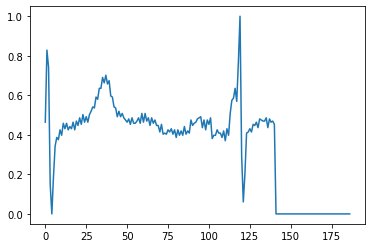

In [13]:
idx = np.random.randint(0, len(x_train))
print('label: ', y_train[idx])
plt.plot(x_train[idx])

In [14]:
np.unique(np.argmax(y_train, axis=-1), return_counts=True), np.unique(np.argmax(y_val, axis=-1), return_counts=True)

((array([0, 1, 2, 3, 4]), array([961,  38,  76,   9,  83])),
 (array([0, 1, 2, 3, 4]), array([247,   7,  22,   1,  15])))

In [15]:
def build_model():
    inputs = layers.Input(shape=x_train.shape[1:])
    conv1_1 = layers.Conv1D(64, (6), activation='relu')(inputs)
    conv1_1 = layers.BatchNormalization()(conv1_1)
    pool1 = layers.Conv1D(64, 3, strides=(2), padding="same")(conv1_1)
    conv2_1 = layers.Conv1D(128, (3), activation='relu')(pool1)
    conv2_1 = layers.BatchNormalization()(conv2_1)
    pool2 = layers.Conv1D(128, 3, strides=(2), padding="same")(conv2_1)
    conv3_1 = layers.Conv1D(256, (3), activation='relu')(pool2)
    conv3_1 = layers.BatchNormalization()(conv3_1)
    pool3 = layers.Conv1D(256, 3, strides=(2), padding="same")(conv3_1)
    pool3 = layers.MaxPooling1D()(pool3)
    flatten = layers.GlobalAveragePooling1D()(pool3)
    dense_end1 = layers.Dense(64, activation='relu')(flatten)
    dense_end2 = layers.Dense(32, activation='relu')(dense_end1)
    main_output = layers.Dense(num_classes, activation='softmax', name='main_output')(dense_end2)
    
    model = models.Model(inputs, main_output)
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [16]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 182, 64)           448       
_________________________________________________________________
batch_normalization (BatchNo (None, 182, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 91, 64)            12352     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 128)           24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 89, 128)           512       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 45, 128)           49280 

In [17]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
            tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)
            ]

In [18]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=1000,
                    callbacks=callback, 
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    )

Epoch 1/1000
37/37 [==============================] - 33s 26ms/step - loss: 0.7852 - accuracy: 0.7670 - val_loss: 1.1657 - val_accuracy: 0.8459
Epoch 2/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.3861 - accuracy: 0.8897 - val_loss: 1.4156 - val_accuracy: 0.0753
Epoch 3/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.3562 - accuracy: 0.8829 - val_loss: 1.4018 - val_accuracy: 0.0753
Epoch 4/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.2683 - accuracy: 0.9214 - val_loss: 1.7199 - val_accuracy: 0.0753
Epoch 5/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.2193 - accuracy: 0.9263 - val_loss: 1.3211 - val_accuracy: 0.0240
Epoch 6/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.1734 - accuracy: 0.9486 - val_loss: 2.3296 - val_accuracy: 0.0616
Epoch 7/1000
37/37 [==============================] - 0s 10ms/step - loss: 0.1871 - accuracy: 0.9430 - val_loss: 1.0412 - val_accuracy: 0.691

In [19]:
def cls_report(path):
    model = models.load_model(path)
    pred = np.argmax(model.predict(x_val), axis=-1)
    print(classification_report(np.argmax(y_val, axis=-1), pred))
    print(confusion_matrix(np.argmax(y_val, axis=-1), pred))

In [ ]:
cls_report('model.h5')